# Interest-rate curves #
## 9. Implied term structures ##

In [1]:
import QuantLib as ql

In [21]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import FuncFormatter
def plot_curve(*curves):
    fig, ax = plt.subplots()
    dates = [today + ql.Period(i, ql.Weeks) for i in range(0, 52 * 5)]
    for (c, style) in curves:
        valid_dates = [d for d in dates if d >= c.referenceDate()]
        rates = [c.forwardRate(d, d + 1, ql.Actual360(), ql.Simple).rate() for d in valid_dates ]
        ax.plot_date([datetime.date(d.year(), d.month(), d.dayOfMonth()) for d in valid_dates], rates, style)
    ax.set_xlim(datetime.date(min(dates).year(), min(dates).month(), min(dates).dayOfMonth()), 
                datetime.date(max(dates).year(), max(dates).month(), max(dates).dayOfMonth()))
    ax.xaxis.set_major_locator(MonthLocator(bymonth = [6,12]))
    ax.xaxis.set_major_formatter(DateFormatter("%b '%y"))
    ax.xaxis.grid(True, 'major')
    ax.xaxis.grid(False, 'minor')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda r, pos: f'{r * 100:.2f}%'))
    fig.autofmt_xdate()
    plt.show()

### The statement of the case ###

In [3]:
today = ql.Date(9, ql.March, 2016)
ql.Settings.instance().evaluationDate = today

In [5]:
helpers = [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100.0)),
                             ql.Period(*tenor), ql.TARGET(), ql.Annual, ql.Unadjusted,
                             ql.Thirty360(ql.Thirty360.European), ql.Euribor6M())
           for tenor, rate in [((6, ql.Months), 0.201),
                               ((2, ql.Years), 0.258),
                               ((5, ql.Years), 0.464),
                               ((10, ql.Years), 1.151),
                               ((15, ql.Years), 1.588)]]
curve = ql.PiecewiseLinearZero(0, ql.TARGET(), helpers, ql.Actual360())

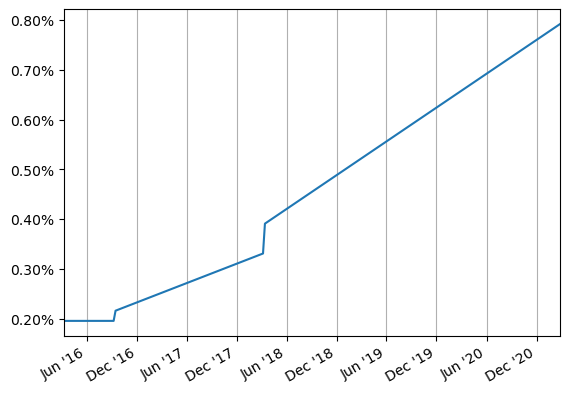

In [22]:
plot_curve((curve, '-'))

In [12]:
future_reference = today + ql.Period(1, ql.Years)
implied_curve = ql.ImpliedTermStructure(ql.YieldTermStructureHandle(curve), future_reference)

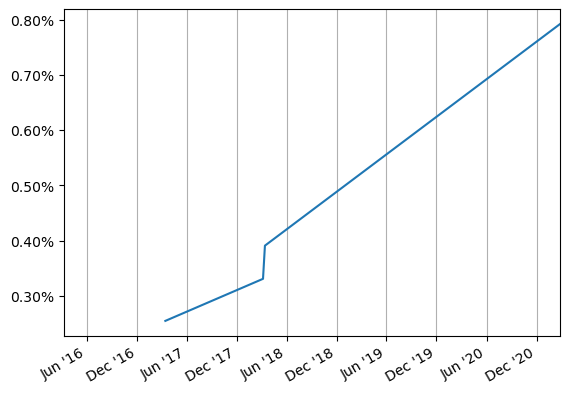

In [23]:
plot_curve((implied_curve, '-'))

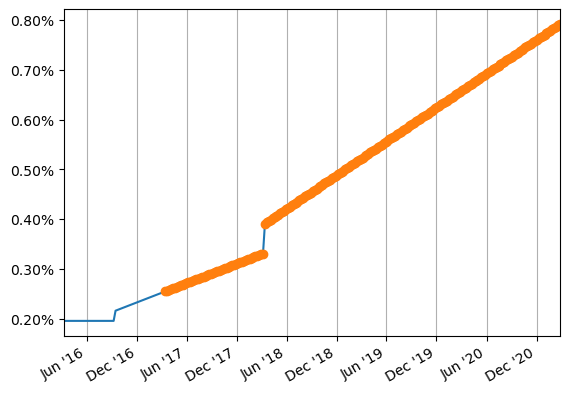

In [24]:
plot_curve((curve, '-'), (implied_curve, 'o'))

In [26]:
dates = [future_reference + ql.Period(i, ql.Years) for i in range(6) ]
rates_1 = [curve.forwardRate(future_reference, d, ql.Actual360(), ql.Continuous).rate() for d in dates]
rates_2 = [implied_curve.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates]
pd.DataFrame(zip(dates, [f'{r * 100:.2f}%' for r in rates_1], [f'{r * 100:.2f}%' for r in rates_2]),
             columns=('Maturity', 'Original forward rate', 'Implied zero rate'), index=[''] * 6)

,Maturity,Original forward rate,Implied zero rate
,"March 9th, 2017",0.25%,0.25%
,"March 9th, 2018",0.29%,0.29%
,"March 9th, 2019",0.37%,0.37%
,"March 9th, 2020",0.45%,0.45%
,"March 9th, 2021",0.52%,0.52%
,"March 9th, 2022",0.67%,0.67%


In [27]:
ql.Settings.instance().evaluationDate = future_reference

In [28]:
rates_3 = [implied_curve.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates]
pd.DataFrame(zip(dates, [f'{r * 100:.2f}%' for r in rates_2], [f'{r * 100:.2f}%' for r in rates_3]),
             columns=('Maturity', 'Before date change', 'After date change'), index=[''] * 6)

,Maturity,Before date change,After date change
,"March 9th, 2017",0.25%,0.20%
,"March 9th, 2018",0.29%,0.22%
,"March 9th, 2019",0.37%,0.25%
,"March 9th, 2020",0.45%,0.32%
,"March 9th, 2021",0.52%,0.39%
,"March 9th, 2022",0.67%,0.46%


### What happened? ###

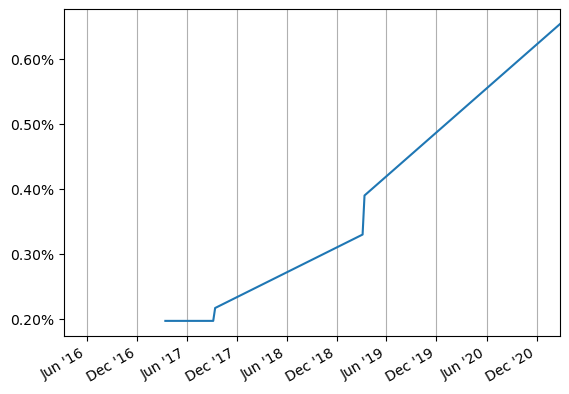

In [29]:
ql.Settings.instance().evaluationDate = future_reference
plot_curve((curve, '-'))

In [30]:
rates_1 = [curve.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates]
rates_2 = [implied_curve.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates]
pd.DataFrame(zip(dates, [f'{r * 100:.2f}%' for r in rates_1], [f'{r * 100:.2f}%' for r in rates_2]),
             columns=('Maturity', 'Original zero rate', 'Implied zero rate'), index=[''] * 6)

,Maturity,Original zero rate,Implied zero rate
,"March 9th, 2017",0.20%,0.20%
,"March 9th, 2018",0.22%,0.22%
,"March 9th, 2019",0.25%,0.25%
,"March 9th, 2020",0.32%,0.32%
,"March 9th, 2021",0.39%,0.39%
,"March 9th, 2022",0.46%,0.46%


In [31]:
ql.Settings.instance().evaluationDate = today

In [32]:
curve.nodes()

((Date(9,3,2016), 0.001954693606572509),
 (Date(12,9,2016), 0.001954693606572509),
 (Date(12,3,2018), 0.002536800732553941),
 (Date(11,3,2021), 0.004572804156623577),
 (Date(11,3,2026), 0.01152478361180485),
 (Date(11,3,2031), 0.01615156507336213))

In [33]:
node_dates, node_rates = zip(*curve.nodes())
frozen_curve = ql.ZeroCurve(node_dates, node_rates, curve.dayCounter())

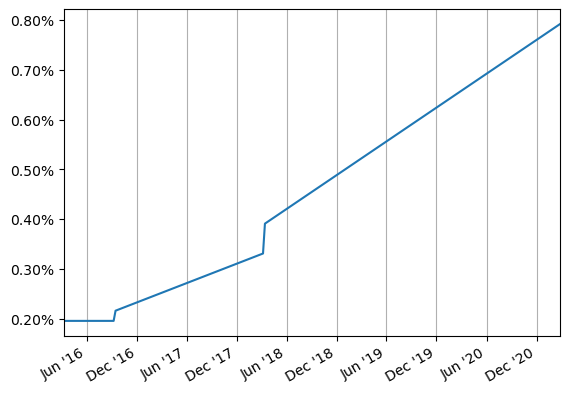

In [34]:
plot_curve((frozen_curve, '-'))

In [35]:
implied_curve = ql.ImpliedTermStructure(ql.YieldTermStructureHandle(frozen_curve), future_reference)

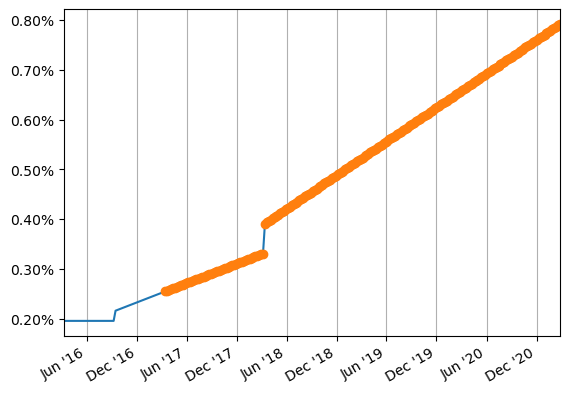

In [36]:
ql.Settings.instance().evaluationDate = future_reference
plot_curve((frozen_curve,'-'), (implied_curve,'o'))

In [37]:
rates_1 = [frozen_curve.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates]
rates_2 = [frozen_curve.forwardRate(future_reference, d, ql.Actual360(), ql.Continuous).rate() for d in dates]
rates_3 = [implied_curve.zeroRate(d, ql.Actual360(), ql.Continuous).rate() for d in dates]
pd.DataFrame(zip(dates,
                 [f'{r * 100:.2f}%' for r in rates_1 ],
                 [f'{r * 100:.2f}%' for r in rates_2 ],
                 [f'{r * 100:.2f}%' for r in rates_3 ]),
             columns=('Maturity', 'Original zero rate', 'Original forward rate', 'Implied zero rate'),
             index=[''] * 6)

,Maturity,Original zero rate,Original forward rate,Implied zero rate
,"March 9th, 2017",0.21%,0.25%,0.25%
,"March 9th, 2018",0.25%,0.29%,0.29%
,"March 9th, 2019",0.32%,0.37%,0.37%
,"March 9th, 2020",0.39%,0.45%,0.45%
,"March 9th, 2021",0.46%,0.52%,0.52%
,"March 9th, 2022",0.60%,0.67%,0.67%
